In [58]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing the Test data

In [59]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd

# URL for MovieLens 100k dataset (you can change the URL for other versions)
url = 'https://files.grouplens.org/datasets/movielens/ml-100k/u.data'

# Load the dataset directly into a pandas DataFrame
df = pd.read_csv(url, sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

print(df.head())

   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


## Mapping the value

In [60]:
# Take the unique value and mapping it
user_mapping = {user_id: idx for idx, user_id in enumerate(df['user_id'].unique())} 
item_mapping = {item_id: idx for idx, item_id in enumerate(df['item_id'].unique())}

# Applying the mappings
df['user_id'] = df['user_id'].map(user_mapping)
df['item_id'] = df['item_id'].map(item_mapping)

print(df.head())

   user_id  item_id  rating  timestamp
0        0        0       3  881250949
1        1        1       3  891717742
2        2        2       1  878887116
3        3        3       2  880606923
4        4        4       1  886397596


## Tranform the data to the matrix 

In [61]:
from sklearn.preprocessing import MinMaxScaler
# Normalize ratings to a scale from 0 to 1 (for a better NN)
scaler = MinMaxScaler()
df['rating']= scaler.fit_transform(df[['rating']])

# Convert to a user-item matrix, the missing value will be 0.01 (avoid similar with the rating 1)
user_item_matrix = df.pivot(index='user_id', columns='item_id', values='rating').fillna(0.01)

print(user_item_matrix)
# Convert to numpy array and then to torch tensors
user_item_matrix = user_item_matrix.values
user_item_matrix_tensor = torch.tensor(user_item_matrix, dtype=torch.float32)

item_id  0     1     2     3     4     5     6     7     8     9     ...  \
user_id                                                              ...   
0        0.50  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  ...   
1        0.01  0.50  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  ...   
2        0.01  0.01  0.00  0.01  0.01  0.01  0.50  0.01  0.75  0.01  ...   
3        0.01  0.01  0.01  0.25  0.01  0.01  0.75  0.01  0.75  0.75  ...   
4        0.01  0.01  0.01  0.01  0.00  0.01  0.01  0.01  0.01  0.01  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
938      0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  ...   
939      0.01  0.01  0.01  0.01  0.75  0.01  0.01  0.01  0.01  0.01  ...   
940      0.01  0.01  0.01  0.01  0.01  0.01  0.50  0.01  0.01  0.01  ...   
941      0.01  0.75  0.01  0.01  0.75  0.01  0.01  0.01  0.01  0.01  ...   
942      0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  ...   

item_id  16

## Split the data

In [62]:
from utils import transform2d_ml

# Create a dataset
dataset = TensorDataset(user_item_matrix_tensor)

# Split the dataset into 70% training, 15% validation, and 15% test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset , [train_size, val_size, test_size])

# Create a dataLoader for training, validation, and testing
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Training

In [63]:
from autorec import AutoRec

model = AutoRec(user_item_matrix.shape[1], 1000 , device)

train_losses, val_losses = model.train_model(train_loader, val_loader,
                                         num_epochs=25,lr=0.002, reg=1e-5)

Epoch 1/25, Train Loss: 0.0522, Val Loss: 0.1709, Time: 0.32s
Epoch 2/25, Train Loss: 0.0276, Val Loss: 0.1676, Time: 0.32s
Epoch 3/25, Train Loss: 0.0264, Val Loss: 0.1639, Time: 0.33s
Epoch 4/25, Train Loss: 0.0259, Val Loss: 0.1622, Time: 0.34s
Epoch 5/25, Train Loss: 0.0247, Val Loss: 0.1598, Time: 0.37s
Epoch 6/25, Train Loss: 0.0241, Val Loss: 0.1571, Time: 0.43s
Epoch 7/25, Train Loss: 0.0226, Val Loss: 0.1514, Time: 0.39s
Epoch 8/25, Train Loss: 0.0207, Val Loss: 0.1479, Time: 0.38s
Epoch 9/25, Train Loss: 0.0202, Val Loss: 0.1458, Time: 0.59s
Epoch 10/25, Train Loss: 0.0193, Val Loss: 0.1441, Time: 0.43s
Epoch 11/25, Train Loss: 0.0193, Val Loss: 0.1439, Time: 0.37s
Epoch 12/25, Train Loss: 0.0189, Val Loss: 0.1436, Time: 0.38s
Epoch 13/25, Train Loss: 0.0190, Val Loss: 0.1434, Time: 0.42s
Epoch 14/25, Train Loss: 0.0187, Val Loss: 0.1432, Time: 0.38s
Epoch 15/25, Train Loss: 0.0189, Val Loss: 0.1430, Time: 0.39s
Epoch 16/25, Train Loss: 0.0188, Val Loss: 0.1428, Time: 0.40s
E

## Plot the Error function

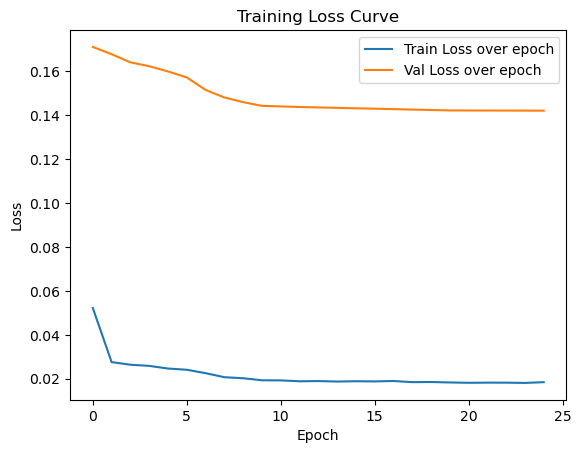

In [64]:
plt.plot( train_losses, label="Train Loss over epoch")
plt.plot( val_losses, label = "Val Loss over epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [65]:
print("Test Loss: ",model.evaluate(test_loader=test_loader))

Test Loss:  tensor(0.1495)
